###Hamiltoniano

El sistema se modela con el modelo de Ising de campo aleatorio. El Hamiltoniano del sistema incorpora, además de la interacción de los espines vecinos, un término de la interacción de cada espín con el campo externo (que va a cambiar en el tiempo), y con un campo local aleatorio. 

$$ H = - \sum_{\langle i, j \rangle} J s_i s_j - \sum_{i}(H(t) + h_i)s_i $$

El campo aleatorio se escoge dentro de una distribución Gaussiana:

$$ P(h) =  \frac{1}{\sqrt{2 \pi} R} e^{-h^2/2R^2} $$

Podemos reescribir al Hamiltoniano de la siguiente forma:


$$ H = - \sum_i \, \left[ \sum_{\langle j_i \rangle} J s_i s_j + (H(t) + h_i)s_i\right] $$

donde usamos la notación $\langle j_i \rangle$ para referirnos a los índices de los espines que son primeros vecinos de $s_i$.

Con la suma explícita corriendo sobre el índice $i$, es claro ahora que para un espín fijo $s_i$, la contribución a la energía total del sistema es:

$$ H_i = - s_i \, \left[J \sum_{\langle j_i \rangle} s_j + H(t) + h_i \right] $$
$$     = - s_i T_i $$

###Evolución

Tomamos la temperatura igual a cero, y hacemos que todos los espines apunten hacia abajo. El campo externo se va a incrementar de $-\infty$ a $+\infty$, adiabáticamente, y posteriormente se va a disminuir en sentido contrario.

Originalmente todos los espines apuntan hacia abajo. El campo $H(t)$ es negativo y más grande en valor absoluto que $h_i$, (ésto es $H(t) + h_i < 0$) así que $H_i <0 \, \, \forall i$. 

Empezamos a incrementar el campo externo y buscamos cuándo es más favorable energéticamente que el espín $s_i$ se voltee. Ésto ocurre cuando $T_i$ se vuelve positivo, y por lo tanto $H_i$ se vuelve positivo. Entonces, $s_i$ cambia de signo y hace que $H_i$ sea de nuevo negativo. 

Cuando hacemos el camino inverso, disminuyendo el campo, $s_i$ apunta en un principio hacia arriba y ocurre lo contrario. $T_i$ originalmente es positivo, y cuando se vuelve negativo $s_i$ se voltea para hacer que $H_i$ se mantenga negativo.

# Modelo

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
using Histeresis

In [12]:
L = 5
N = L^2
m = edo_inicial(L)

@time mag, hs = magnetizacion_aumenta_H(m) ;

elapsed time: 0.000230483 seconds (43720 bytes allocated)


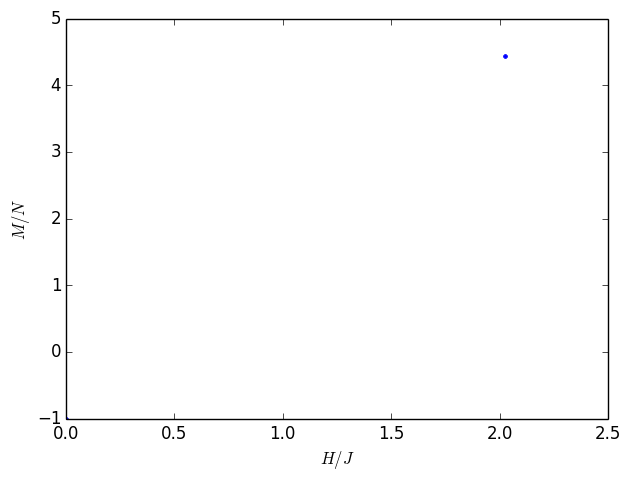

In [13]:
figure(figsize=(7,5))

ylabel(L"M/N")
xlabel(L"H/J") #J=1
plot(hs,mag/N, ".");

In [28]:
L = 5
N = L^2
m = edo_inicial(L)

@time mag, hs = magnetizacion_aumenta_H(m) ;

elapsed time: 0.000154767 seconds (20824 bytes allocated)


In [29]:
@time mag, hs = magnetizacion_disminuye_H(m) ;

LoadError: interrupt
while loading In[29], in expression starting on line 56

In [30]:
m

5x5 Array{Int64,2}:
 1  -1  -1  -1  1
 1  -1  -1   1  1
 1  -1   1   1  1
 1   1   1   1  1
 1   1  -1   1  1

# Prueba

In [128]:
type MicroEstado
    σ::Array{Int,2}
    h::Array{Float64,2}
    #Vamos a suponer que todas las configuraciones son cuadradas
    L::Int
end

import Base.show

show(io::IO, m::MicroEstado) = print(io, m.σ)

function edo_inicial(L::Int, R)
    σ = -ones(Int, (L,L))

    h = Array(Float64, (L,L))
    for i in 1:L^2
        # Temporal, hay que cambiar la distribución
        h[i] = R*randn()
    end

    MicroEstado(σ, h, L)
end

edo_inicial (generic function with 2 methods)

In [89]:
# Ya no calculamos la energía, así que cambié nombre
function criterio_espin(m::MicroEstado, i::Int, j::Int)
    σ = m.σ ; L = m.L
	
	# OJO: multiplicar por σ[i,j] es un problema por que no estamos incluyendo a H(t),
	# lo quitamos
    σ[mod1(i-1, L),j] + σ[mod1(i+1, L),j] + σ[i,mod1(j-1, L)] + σ[i,mod1(j+1, L)] + m.h[i,j]
end

criterio_espin (generic function with 1 method)

In [24]:
function voltea_espin_abajo!(m::MicroEstado, i::Int, j::Int)
    if m.σ[i,j] == -1
        m.σ[i,j] *= -1
    end
end

voltea_espin_abajo! (generic function with 1 method)

In [15]:
function max_abajo(m::MicroEstado, valor_min)
    tmp = Array(Float64,(m.L,m.L))

    for i = 1:m.L, j = 1:m.L
        if m.σ[i,j] == -1
            tmp[i,j] = criterio_espin(m,i,j)
        else
            tmp[i,j] = valor_min
        end
    end

    f = findmax(tmp) # Da el máximo y el índice lineal del máximo
    i = mod1(f[2], m.L)
    j = int(ceil(f[2]/m.L))

    f[1], i, j
end

max_abajo (generic function with 1 method)

In [18]:
function espines_vecinos_abajo(m::MicroEstado,i::Int,j::Int)
    vecinos = [ (mod1(i-1,m.L),j), (mod1(i+1,m.L),j), (i,mod1(j-1,m.L)), (i,mod1(j+1,m.L)) ]
    vecinos_abajo = (Int,Int)[]

    for k in vecinos
        if m.σ[k...] == -1
            push!(vecinos_abajo, k)
        end
    end

    vecinos_abajo
end

espines_vecinos_abajo (generic function with 1 method)

In [113]:
function avalancha_abajo(m::MicroEstado, i::Int, j::Int, H::Float64)
    voltea_espin_abajo!(m,i,j)
    #puede haber un problema, si se escoje de entrada un espín que ya está volteado
    espines_volteados = [(i,j)]

    candidatos = espines_vecinos_abajo(m,i,j)

    while length(candidatos) > 0
        nuevos_candidatos = (Int,Int)[]

        for k in candidatos
            if m.σ[k...] == -1
                if  criterio_espin(m,k...) + H > 0
                    voltea_espin_abajo!(m,k...)
                    push!(espines_volteados,k)
                    nuevos_candidatos = vcat(nuevos_candidatos, espines_vecinos_abajo(m,k...))
                end
            end
        end

        candidatos = nuevos_candidatos
    end

    m, espines_volteados
end

avalancha_abajo (generic function with 1 method)

In [114]:
magnetizacion(m::MicroEstado) = sum(m.σ)

function magnetizacion_aumenta_H(m::MicroEstado)
    valor_min = minimum(m.h)-5
    N = m.L^2
    mag = [magnetizacion(m)]
	# Cambiar este cero
    hs = [0.]

    while mag[end] < N
        H,i,j = max_abajo(m, valor_min)
        H *= -1
        push!(hs, H)
        m, volteados = avalancha_abajo(m,i,j,H)
        ΔM = 2*length(volteados)
        #Ojo: esto sólo sirve porque volteamos espines hacia arriba
        push!(mag, mag[end] + ΔM)
    end

    mag, hs
end

magnetizacion_aumenta_H (generic function with 1 method)

In [116]:
magnetizacion_aumenta_H(m)

([-25,25],[0.0,2.33925])

In [135]:
L = 50
R = 4
N = L^2
m = edo_inicial(L,R)

@time mag, hs = magnetizacion_aumenta_H(m);

elapsed time: 0.482759792 seconds (26507256 bytes allocated, 19.58% gc time)


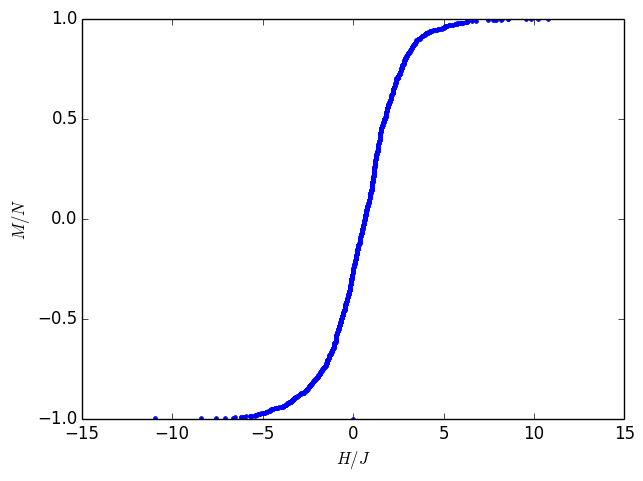

In [136]:
figure(figsize=(7,5))
ylabel(L"M/N")
xlabel(L"H/J") #J=1
plot(hs,mag/N, ".");